In [1]:
# Description: Figure 2.
#              -Circumpolar section of temperature
#               above freezing point along the 1000 m isobath.
#              -CT-SA diagrams averaged within segments and over 2005-2009.
#
# Author:      André Palóczy Filho
# E-mail:      paloczy@gmail.com
# Date:        December/2017

import sys
sys.path.append('../../misc')
sys.path.append('/home/andre/Dropbox/python-modules/pygamman')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from reproducibility import savefig
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from gsw import SA_from_SP, SP_from_SA, CT_from_pt, t_from_CT, p_from_z
from netCDF4 import Dataset
import gsw
from os.path import isfile
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from cmocean import cm as cmo
from local_utils import lon180to360, lon360to180, near, near2, stripmsk
from local_utils import bmap_antarctica, gamman, isopyc_depth, montecarlo_gamman

def zinterp_obs2modgrid(T, S, z, zg):
    """
    Interpolates observed profiles (non-uniform in depth)
    to the model vertical grid (uniform in depth).
    """
    zg = np.flipud(zg)
    n = len(T)
    skel = np.ones((zg.size, n))*np.nan
    Tg, Sg = skel.copy(), skel.copy()
    N = range(n)

    # Profiles upside down for interpolating.
    z = [np.flipud(z[m]) for m in range(n)]
    T = [np.flipud(T[m]) for m in range(n)]
    S = [np.flipud(S[m]) for m in range(n)]
    # Data deeper than the deepest data point are set to NaN.
    for m in N:
        Tg[:,m] = np.interp(zg, z[m], T[m], right=np.nan, left=np.nan)
        Sg[:,m] = np.interp(zg, z[m], S[m], right=np.nan, left=np.nan)

    # Profiles rightside up.
    Tg = np.array([np.flipud(Tg[:,m]) for m in N]).T
    Sg = np.array([np.flipud(Sg[:,m]) for m in N]).T

    return Tg, Sg

plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
#===
plt.close('all')

bdry_isobs = [800, 2500]
misob = 1000 # Isobath to plot the (T - Tf) section on.
alpha = 0.99
dzref = 0.1

Tg_stdev_instrumental = 0.1 # [deg C].
Sg_stdev_instrumental = 0.1 # [unitless].

# Get segment lat/lon limits.
segs_lims = {
'Bellingshausen':[-100., -75., -77., -60.],
'S-AP':[-75., -64., -74., -60.],
'N-AP':[-64., -53., -74., -60.],
'W-EA':[-11., 65., -72., -60.],
'C-EA':[65., 100., -72., -60.],
'E-EA':[100., 165., -72., -60.]
}

cm2m = 1e-2
head = '../../data_reproduce_figs/'
fnamez_isobs = head + 'isobaths.nc'
fnamez_obs = head + 'MEOPgrd_2005-2009.npz'
fname_mod = head + 'large_files/' + 'TS-UV-SOsubset_avg_2005-2009_from_monthly_fields.nc'
fname_mod2obs = head + 'MEOPgrd_2005-2009_interp_mod2obs.npz'
fmt = 'png'
iisob, oisob = np.min(bdry_isobs), np.max(bdry_isobs)

fnamez_obsinvol = head + 'cache/' + 'cache_msk%dm-%dm_obsin_2005-2009.npz'%(iisob, oisob)

print("Loading model isobath coordinates.")
ncx = Dataset(fnamez_isobs)
di = ncx["%d m isobath (U-points)"%iisob]['diso'][:]
xi = ncx["%d m isobath (U-points)"%iisob]['xiso'][:]
yi = ncx["%d m isobath (U-points)"%iisob]['yiso'][:]
Ii = ncx["%d m isobath (U-points)"%iisob]['i'][:]
Ji = ncx["%d m isobath (U-points)"%iisob]['j'][:]
do = ncx["%d m isobath (U-points)"%oisob]['diso'][:]
xo = ncx["%d m isobath (U-points)"%oisob]['xiso'][:]
yo = ncx["%d m isobath (U-points)"%oisob]['yiso'][:]
Io = ncx["%d m isobath (U-points)"%oisob]['i'][:]
Jo = ncx["%d m isobath (U-points)"%oisob]['j'][:]
#
ncxm = Dataset(fnamez_isobs)
dm = ncxm["%d m isobath (U-points)"%misob]['diso'][:]
xm = ncxm["%d m isobath (U-points)"%misob]['xiso'][:]
ym = ncxm["%d m isobath (U-points)"%misob]['yiso'][:]
Im = ncxm["%d m isobath (U-points)"%misob]['i'][:]
Jm = ncxm["%d m isobath (U-points)"%misob]['j'][:]

print("Loading MEOP data.")
d = np.load(fnamez_obs)
for k, v in d.iteritems():
    if k not in ['CT', 'T', 'SA', 'SP', 'z', 'p', 'lon', 'lat']:
        continue
    print('Load MEOP %s'%k)
    vars().update({k:v})

dm2s = np.load(fname_mod2obs)
SAmod2obs = dm2s['SAm2s_all'].squeeze()
CTmod2obs = dm2s['CTm2s_all'].squeeze()
SAmod2obs = SAmod2obs.T
CTmod2obs = CTmod2obs.T

## Get seal data points within the polygon defined by the two isobaths.
fig, ax = plt.subplots()
m = bmap_antarctica(ax)
xim, yim = m.projtran(xi, yi)
xom, yom = m.projtran(xo, yo)
polyi = Path(np.hstack((xim[:,np.newaxis], yim[:,np.newaxis])), closed=True)
polyo = Path(np.hstack((xom[:,np.newaxis], yom[:,np.newaxis])), closed=True)
plt.close()

if isfile(fnamez_obsinvol):
    d = np.load(fnamez_obsinvol)
    for k, v in d.iteritems():
        vars().update({k:v})
else:
    count = 0
    nprofiles = lon.size
    ini, ino = np.array([]), np.array([])
    for xx, yy in zip(lon, lat):
        print("Profile %d of %d"%(count+1, nprofiles))
        xx, yy = m.projtran(xx, yy)
        ini = np.append(ini, polyi.contains_point((xx,yy)))
        ino = np.append(ino, polyo.contains_point((xx,yy)))
        count+=1
    np.savez(fnamez_obsinvol, ini=ini, ino=ino, inner_isob=iisob, outer_isob=oisob,
    xi=xi.data, yi=yi.data, xo=xo.data, yo=yo.data, xim=xim.data, yim=yim.data,
    xom=xom.data, yom=yom.data)

ini, ino = map(np.bool8, (ini, ino))
involobs = np.logical_and(ino, ~ini)
xobs, yobs = lon[involobs], lat[involobs]
xobs_all, yobs_all = xobs.copy(), yobs.copy()
xobsm, yobsm = m.projtran(xobs, yobs)
CTobs = CT[involobs]
SAobs = SA[involobs]
Tobs = T[involobs]
SPobs = SP[involobs]
zobs = z[involobs]
pobs = p[involobs]

# Load masks for the model grid.
fnamez_modo = head + 'volmsk%dm.npz'%oisob
fnamez_modi = head + 'volmsk%dm.npz'%iisob
inimod, inomod = np.load(fnamez_modi)['volmsk'], np.load(fnamez_modo)['volmsk']
inimod, inomod = map(np.bool8, (inimod, inomod))
involmod = np.logical_and(inomod, ~inimod)

print("Loading model T/S fields.")
ncm = Dataset(fname_mod)
PTmod = ncm.variables['TEMP'][0, ...]
SPmod = ncm.variables['SALT'][0, ...]
PTmodf, SPmodf = PTmod.copy(), SPmod.copy()
PTmod = PTmod[:, involmod]
SPmod = SPmod[:, involmod]
xmodf = lon360to180(ncm.variables['TLONG'][:])
ymodf = ncm.variables['TLAT'][:]
xmod = xmodf[involmod]
ymod = ymodf[involmod]
xmodm, ymodm = m.projtran(xmod, ymod)
zmod = -ncm.variables['z_t'][:]*cm2m
pmod = p_from_z(zmod, ymod.mean())
nz = zmod.size
dz = -(zmod[1:] - zmod[:-1])
hdepth = dz.sum()

SAmod = SA_from_SP(SPmod, pmod[:, np.newaxis], xmod[np.newaxis,...], ymod[np.newaxis,...])
CTmod = CT_from_pt(SAmod, PTmod)

# Extract model profiles within the bounding isobaths.
nprofiles_mod = xmod.size
print("Loaded model fields.")
print("Total **OBSERVED** profiles within the %d m and %d m isobaths: %d"%(iisob, oisob, involobs.sum()))
print("Total **MODEL** profiles within the %d m and %d m isobaths: %d"%(iisob, oisob, involmod.sum()))

# Interpolate all seal profiles to POP depths first, then do
# the block-averaging to compare segments.
CTobs, SAobs = zinterp_obs2modgrid(CTobs, SAobs, zobs, zmod)
Tobs, SPobs = zinterp_obs2modgrid(Tobs, SPobs, zobs, zmod)

# Estimate of number of degrees of freedom in model profiles.
Ly = 20 # Decorrelation along-slope length scale [km].
Lt = 30 # Decorrelation time scale [days].
Nt = 5*365/Lt
Nx = 1  # Assume a single DoF in the cross-slope direction for all segments,
        # because they are all very thin.

CTobs_mean, SAobs_mean, GAMMAobs_mean = dict(), dict(), dict()
CTobs_std, SAobs_std, GAMMAobs_std = dict(), dict(), dict()
Tobs_mean, SPobs_mean = dict(), dict()
CTmod2obs_mean, SAmod2obs_mean, GAMMAmod2obs_mean = dict(), dict(), dict()
CTmod2obs_std, SAmod2obs_std, GAMMAmod2obs_std = dict(), dict(), dict()
CTobsSE, SAobsSE = dict(), dict()
TobsSE, SPobsSE = dict(), dict()
#
GAMMAmod_mean = dict()
CTmod_mean, SAmod_mean = dict(), dict()
CTmod_std, SAmod_std = dict(), dict()
CTmodSE, SAmodSE = dict(), dict()
CTnrmsd, SAnrmsd = dict(), dict()
Nprofsobs, Nprofsmod = dict(), dict()
seal_maxdepthdive, mod_maxdepth = dict(), dict()
Xobs, Yobs = dict(), dict()

# Find indices of the observed and model profiles
# inside each segment of the strip.
dilb_segs = dict()
dmlb_segs = dict()
dmmb_segs = dict()
dmrb_segs = dict()

n = 0
figg, axx = plt.subplots()
dirb_segs = dict()
for segname, segbbox in segs_lims.items():
    print('Segment: %s'%segname)
    xilseg, xirseg, yilseg, yirseg = segbbox
    idxil = near(xi, xilseg, return_index=True)
    idxir = near(xi, xirseg, return_index=True)
    idxml = near(xm, xilseg, return_index=True)
    idxmr = near(xm, xirseg, return_index=True)

    # Swap indices if they are in the reverse order.
    if di[idxil] > di[idxir]:
        idxil, idxir = idxir, idxil
    if dm[idxml] > dm[idxmr]:
        idxml, idxmr = idxmr, idxml

    xilb, xirb = xi[idxil], xi[idxir]
    yilb, yirb = yi[idxil], yi[idxir]
    dilb, dirb = di[idxil], di[idxir]
    dmlb, dmrb = dm[idxml], dm[idxmr]
    dmmb = 0.5*(dmlb + dmrb)
    dilb_segs.update({segname:dilb})
    dirb_segs.update({segname:dirb})
    #
    dmlb_segs.update({segname:dmlb})
    dmmb_segs.update({segname:dmmb})
    dmrb_segs.update({segname:dmrb})

    # Next, find the closest points on the outer
    # isobath to make a closed polygon.
    idxol = near2(xo, yo, xilb, yilb, return_index=True)[0]
    idxor = near2(xo, yo, xirb, yirb, return_index=True)[0]

    # Swap indices if they are in the reverse order.
    if do[idxol] > do[idxor]:
        idxol, idxor = idxor, idxol

    print(xilb,xirb)
    xolb, xorb = xo[idxol], xo[idxor]
    yolb, yorb = yo[idxol], yo[idxor]
    dolb, dorb = do[idxol], do[idxor]

    xilbm, yilbm = m.projtran(xilb, yilb)
    if xilseg>xirseg: # If the segment crosses the International Date Line.
        polyb1W = np.vstack((xim[:idxil][np.newaxis, :], yim[:idxil][np.newaxis, :])).T
        polyb1E = np.vstack((xim[idxir:][np.newaxis, :], yim[idxir:][np.newaxis, :])).T
        polyb1 = np.vstack((polyb1E, polyb1W))
        polyb2W = np.vstack((xom[:idxol], yom[:idxol])).T
        polyb2E = np.vstack((xom[idxor:], yom[idxor:])).T
        polyb2 = np.flipud(np.vstack((polyb2E, polyb2W)))
        xirbm, yirbm = m.projtran(xirb, yirb)
        polyclose = np.expand_dims((xirbm, yirbm), 0)
    else:
        polyb1 = np.vstack((xim[idxil:idxir], yim[idxil:idxir])).T
        polyb2 = np.vstack((np.flipud(xom[idxol:idxor]), np.flipud(yom[idxol:idxor]))).T
        polyclose = np.expand_dims((xilbm, yilbm), 0)

    polyblk = np.vstack((polyb1, polyb2, polyclose))
    polyblk = Path(polyblk, closed=True)

    inblkobs = np.array([polyblk.contains_point((x0m, y0m)) for x0m, y0m in zip(xobsm, yobsm)])
    inblkmod = np.array([polyblk.contains_point((x0m, y0m)) for x0m, y0m in zip(xmodm, ymodm)])

    # fig, ax = plt.subplots()
    aux = polyblk.vertices
    xpl, ypl = m.projtran(aux[:,0], aux[:,1], inverse=True)
    axx.plot(xpl, ypl, marker='.')

    if n==0:
        axx.plot(xobs_all, yobs_all, 'gray', linestyle='none', marker='.', ms=2)

    Nobs = inblkobs.sum()
    Nmod = inblkmod.sum()
    Nprofsobs.update({segname:Nobs})
    Nprofsmod.update({segname:Nmod})
    Nprofsmod.update({segname:Nmod})
    print("OBSERVED/MODEL profiles inside %s segment:    %d / %d"%(segname, Nobs, Nmod))

    CTsegmod2obs = CTmod2obs[:, inblkobs]
    SAsegmod2obs = SAmod2obs[:, inblkobs]
    #
    CTsegobs = CTobs[:, inblkobs]
    SAsegobs = SAobs[:, inblkobs]
    SPsegobs = SPobs[:, inblkobs]
    Tsegobs = Tobs[:, inblkobs]
    xsegobs, ysegobs = xobs[inblkobs], yobs[inblkobs]
    GAMMAsegobs = Tsegobs*np.nan
    print("Calculating neutral density for observed profiles.")
    for pn in range(Nobs):
        GAMMAsegobs[:,pn], _, _ = gamman(SPsegobs[:,pn], Tsegobs[:,pn], pmod, xsegobs[pn], ysegobs[pn])
    # Number of data points at each depth.
    CTobsn = np.sum(~np.isnan(CTsegobs), axis=1)
    SAobsn = np.sum(~np.isnan(SAsegobs), axis=1)
    assert np.all(CTobsn==SAobsn), "Number of valid observed CT and SA points are different."
    profNobs = np.float32(CTobsn)

    # Calculate mean _observed_ CT/SA/GAMMA profile in this segment.
    CTsegmod2obs_mean = np.nanmean(CTsegmod2obs, axis=1)
    SAsegmod2obs_mean = np.nanmean(SAsegmod2obs, axis=1)
    CTsegmod2obs_std = np.nanstd(CTsegmod2obs, axis=1)
    SAsegmod2obs_std = np.nanstd(SAsegmod2obs, axis=1)
    #
    CTsegobs_mean = np.nanmean(CTsegobs, axis=1)
    SAsegobs_mean = np.nanmean(SAsegobs, axis=1)
    Tsegobs_mean = np.nanmean(Tsegobs, axis=1)
    SPsegobs_mean = np.nanmean(SPsegobs, axis=1)
    GAMMAsegobs_mean = np.nanmean(GAMMAsegobs, axis=1)
    CTsegobs_std = np.nanstd(CTsegobs, axis=1)
    SAsegobs_std = np.nanstd(SAsegobs, axis=1)
    Tsegobs_std = np.nanstd(Tsegobs, axis=1)
    SPsegobs_std = np.nanstd(SPsegobs, axis=1)
    GAMMAsegobs_std = np.nanstd(GAMMAsegobs, axis=1)

    # Calculate the standard error profiles for the block-averaged CT and SA,
    # assuming all observed profiles are independent and using the
    # sample standard deviation in each block.
    #
    # Thou shalt not divide by zero.
    profNobs[profNobs==0] = np.nan
    CTsegobsSE = np.sqrt(CTsegobs_std**2 + Tg_stdev_instrumental**2)/np.sqrt(profNobs)
    SAsegobsSE = np.sqrt(SAsegobs_std**2 + Sg_stdev_instrumental**2)/np.sqrt(profNobs)
    #
    TsegobsSE = np.sqrt(Tsegobs_std**2 + Tg_stdev_instrumental**2)/np.sqrt(profNobs)
    SPsegobsSE = np.sqrt(SPsegobs_std**2 + Sg_stdev_instrumental**2)/np.sqrt(profNobs)

    CTmod2obs_mean.update({segname:CTsegmod2obs_mean})
    SAmod2obs_mean.update({segname:SAsegmod2obs_mean})
    CTobs_mean.update({segname:CTsegobs_mean})
    SAobs_mean.update({segname:SAsegobs_mean})
    Tobs_mean.update({segname:Tsegobs_mean})
    SPobs_mean.update({segname:SPsegobs_mean})
    GAMMAobs_mean.update({segname:GAMMAsegobs_mean})
    CTmod2obs_std.update({segname:CTsegmod2obs_std})
    SAmod2obs_std.update({segname:SAsegmod2obs_std})
    CTobs_std.update({segname:CTsegobs_std})
    SAobs_std.update({segname:SAsegobs_std})
    GAMMAobs_std.update({segname:GAMMAsegobs_std})
    CTobsSE.update({segname:CTsegobsSE})
    SAobsSE.update({segname:SAsegobsSE})
    TobsSE.update({segname:TsegobsSE})
    SPobsSE.update({segname:SPsegobsSE})
    Xobs.update({segname:xsegobs})
    Yobs.update({segname:ysegobs})

    CTsegmod = CTmod[:, inblkmod]
    SAsegmod = SAmod[:, inblkmod]
    SPsegmod = SPmod[:, inblkmod]
    Tsegmod = t_from_CT(SAsegmod, CTsegmod, pmod[:, np.newaxis])
    # Number of data points at each depth.
    CTmodn = np.sum(~CTsegmod.mask, axis=1)
    SAmodn = np.sum(~SAsegmod.mask, axis=1)
    assert np.all(CTmodn==SAmodn), "Number of valid model CT and SA points are different."
    ffz=CTsegmod.mask
    fzlevbots = []
    for nn in range(Nmod):
        if ffz[:,nn].all():
            continue
        else:
            ffzn=~ffz[:,nn]
            fzlevbots.append(np.where(ffzn)[0][-1]) # Index of deepest level with data.
    fzlevbot = np.array(fzlevbots).max()

    # Get depth of deepest seal profile and model profile in this block.
    sealdeepestdive = -np.nanmin([a.min() for a in zobs[inblkobs]])
    seal_maxdepthdive.update({segname:sealdeepestdive})
    mod_maxdepth.update({segname:-zmod[fzlevbot]})

    # Calculate mean _model_ T/S profile in this segment.
    CTsegmod_mean = CTsegmod.mean(axis=1)
    SAsegmod_mean = SAsegmod.mean(axis=1)
    CTsegmod_std = CTsegmod.std(axis=1)
    SAsegmod_std = SAsegmod.std(axis=1)

    GAMMAsegmod = CTsegmod*np.nan
    xsegmod, ysegmod = xmod[inblkmod], ymod[inblkmod]
    print("Calculating neutral density for model profiles.")
    for pn in range(Nmod):
        xsegmodn, ysegmodn = xsegmod[pn], ysegmod[pn]
        GAMMAsegmod[:,pn], _, _ = gamman(SPsegmod[:, pn], Tsegmod[:, pn], pmod, xsegmodn, ysegmodn)
    GAMMAsegmod = np.ma.masked_invalid(GAMMAsegmod)
    GAMMAsegmod_mean = GAMMAsegmod.mean(axis=1)

    # Calculate the standard error profiles for the block-averaged CT and SA,
    # using the sample standard deviation in each block, and
    # assuming conservative decorrelation length and time scales.
    Lseg = dirb - dilb # Length of the inner isobath of this segment [km].
    print("Segment along-slope length:   %.0f km"%Lseg)
    Ny = Lseg/Ly
    EDoFmod = Nx*Ny*Nt
    CTsegmodSE = CTsegmod_std/np.sqrt(EDoFmod)
    SAsegmodSE = SAsegmod_std/np.sqrt(EDoFmod)

    GAMMAmod_mean.update({segname:GAMMAsegmod_mean})
    CTmod_mean.update({segname:CTsegmod_mean})
    SAmod_mean.update({segname:SAsegmod_mean})
    CTmod_std.update({segname:CTsegmod_std})
    SAmod_std.update({segname:SAsegmod_std})
    CTmodSE.update({segname:CTsegmodSE})
    SAmodSE.update({segname:SAsegmodSE})

    # T and S normalized RMS differences (observed - model).
    dCT = CTsegobs_mean - CTsegmod_mean
    dSA = SAsegobs_mean - SAsegmod_mean
    nzmin = np.min([np.sum(~CTsegmod_mean.mask), np.sum(~np.isnan(CTsegobs_mean))])
    nrmsdCT = np.sqrt(np.nansum(dCT**2)/nzmin)
    nrmsdSA = np.sqrt(np.nansum(dSA**2)/nzmin)
    CTnrmsd.update({segname:nrmsdCT})
    SAnrmsd.update({segname:nrmsdSA})

    n+=1

pmod = pmod[:, np.newaxis]
fmisob=zmod>-misob # Only down to the dept of the middle isobath.
xmodf, ymodf = xmodf[np.newaxis, Im, Jm], ymodf[np.newaxis, Im, Jm]
SPmodsecm = SPmodf[:, Im, Jm]
SPmodsecm, pmod = SPmodsecm[fmisob, :], pmod[fmisob, :]
SAmodsecm = SA_from_SP(SPmodsecm, pmod, xmodf, ymodf)
if False: # Get the minimum freezing temperature on the section.
    CTfm = gsw.freezing.CT_freezing(SAmodsecm, pmod)
    print("")
    print("Minimum freezing CT along TIME-MEAN %d m section:  %f degC"%(misob, CTfm.min()))
else: # Constant Tf.
    CTfm = -2.631595 # [degC].
CTmodsecm = CT_from_pt(SAmodsecm, PTmodf[:, Im, Jm][fmisob, ...])
Tmodsecm = t_from_CT(SAmodsecm, CTmodsecm, pmod)

#---
CTCTfmodsecm = CTmodsecm - CTfm
CTCTfmodsecm[CTCTfmodsecm<0] = 0

Loading model isobath coordinates.
Loading MEOP data.
Load MEOP CT
Load MEOP SP
Load MEOP p
Load MEOP z
Load MEOP lat
Load MEOP lon
Load MEOP SA
Load MEOP T
Loading model T/S fields.
Loaded model fields.
Total **OBSERVED** profiles within the 800 m and 2500 m isobaths: 5485
Total **MODEL** profiles within the 800 m and 2500 m isobaths: 70168
Segment: Bellingshausen
-100.0 -75.0
OBSERVED/MODEL profiles inside Bellingshausen segment:    693 / 2558
Calculating neutral density for observed profiles.
Calculating neutral density for model profiles.
Segment along-slope length:   2202 km
Segment: S-AP
-75.0 -64.0
OBSERVED/MODEL profiles inside S-AP segment:    345 / 543
Calculating neutral density for observed profiles.
Calculating neutral density for model profiles.
Segment along-slope length:   1075 km
Segment: N-AP
-64.0 -53.0
OBSERVED/MODEL profiles inside N-AP segment:    3025 / 3940
Calculating neutral density for observed profiles.
Calculating neutral density for model profiles.
Segment

In [2]:
isoneutrals = [27.98]

hgamman_segavg = dict()
hgamman_segerr = dict()
zmodf = zmod.copy()
zmod = zmod[fmisob]
print("Calculating isoneutral depths and standard errors for observed profiles.")
for segname in segs_lims.keys():
    sp_mean = SPobs_mean[segname][fmisob]
    spSE = SPobsSE[segname][fmisob]
    t_mean = Tobs_mean[segname][fmisob]
    tSE = TobsSE[segname][fmisob]
    x0 = Xobs[segname].mean()
    y0 = Yobs[segname].mean()

    hgamman_segmean, hgamman_err, hgamman_mc = montecarlo_gamman(sp_mean, spSE, t_mean, tSE,
                                                                pmod, zmod, x0, y0, isoneutrals, dzref,
                                                                nmc=1e3, alpha=alpha, nbins=50,
                                                                plot_cdf=False, verbose=False)
    hgamman_segavg.update({segname:hgamman_segmean})
    hgamman_segerr.update({segname:hgamman_err})

Calculating isoneutral depths and standard errors for observed profiles.


In [3]:
# Calculate model gamma_n section.
gamman_modsecm = CTCTfmodsecm*np.nan
print("Calculating neutral density for model section.")
xmodf, ymodf = xmodf.squeeze(), ymodf.squeeze()
for pn in range(len(Im)):
    gamman_modsecm[:,pn], _, _ = gamman(SPmodsecm[:,pn], Tmodsecm[:,pn], pmod, xmodf[pn], ymodf[pn])
gamman_modsecm = np.ma.masked_invalid(gamman_modsecm)
gamman_modsecm = np.ma.masked_less(gamman_modsecm, 0)

Calculating neutral density for model section.


Plotting segment: Bellingshausen
Bellingshausen depth-averaged (CT_obs - CT_mod) difference:   0.30 degC = 10.69 %
Plotting segment: S-AP
S-AP depth-averaged (CT_obs - CT_mod) difference:   0.18 degC = 6.31 %
Plotting segment: N-AP
N-AP depth-averaged (CT_obs - CT_mod) difference:   0.06 degC = 2.19 %
Plotting segment: W-EA
W-EA depth-averaged (CT_obs - CT_mod) difference:   0.14 degC = 5.33 %
Plotting segment: C-EA
C-EA depth-averaged (CT_obs - CT_mod) difference:   0.29 degC = 11.28 %
Plotting segment: E-EA
E-EA depth-averaged (CT_obs - CT_mod) difference:   0.25 degC = 9.83 %


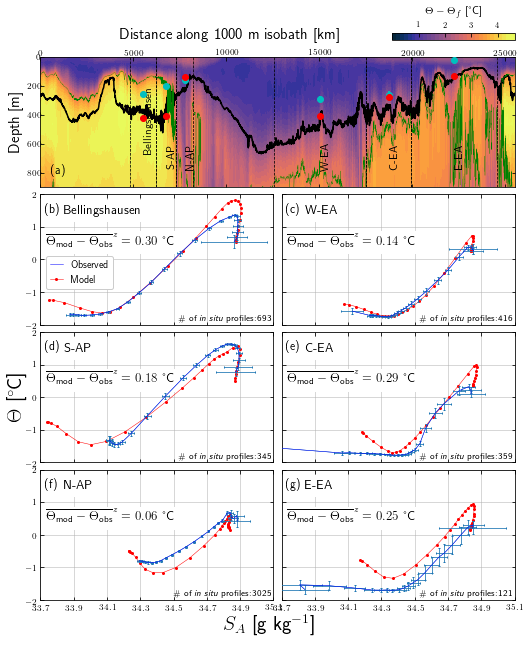

In [4]:
##############
## Figure 2 ##
##############

figsize = (8.5, 10)#(10, 13.5) # (8.5, 10)
subpltshp = (4, 2)
isoCTCTf = [3.0]
figname = 'fig2'
fmt = 'png'

fig = plt.figure(figsize=figsize)
ax1 = plt.subplot2grid(subpltshp, (0, 0), fig=fig, colspan=2)
ax2 = plt.subplot2grid(subpltshp, (1, 0), fig=fig)
ax3 = plt.subplot2grid(subpltshp, (1, 1), fig=fig)
ax4 = plt.subplot2grid(subpltshp, (2, 0), fig=fig)
ax5 = plt.subplot2grid(subpltshp, (2, 1), fig=fig)
ax6 = plt.subplot2grid(subpltshp, (3, 0), fig=fig)
ax7 = plt.subplot2grid(subpltshp, (3, 1), fig=fig)

segs_lims = {
'Bellingshausen':[-100., -75., -77., -60.],
'S-AP':[-75., -64., -74., -60.],
'N-AP':[-64., -53., -74., -60.],
'W-EA':[-11., 65., -72., -60.],
'C-EA':[65., 100., -72., -60.],
'E-EA':[100., 165., -72., -60.]
}

SAlims = (33.7, 35.0)
CTlims = (-2, 2)
dSAtks = 0.2
dCTtks = 1
SAtks = np.arange(SAlims[0], SAlims[-1]+dSAtks, dSAtks)
CTtks = np.arange(CTlims[0], CTlims[-1]+dCTtks, dCTtks)
ax2.set_xlim(SAlims)
ax3.set_xlim(SAlims)
ax4.set_xlim(SAlims)
ax5.set_xlim(SAlims)
ax6.set_xlim(SAlims)
ax7.set_xlim(SAlims)
ax2.set_ylim(CTlims)
ax3.set_ylim(CTlims)
ax4.set_ylim(CTlims)
ax5.set_ylim(CTlims)
ax6.set_ylim(CTlims)
ax7.set_ylim(CTlims)
ax2.xaxis.set_ticks(SAtks)
ax3.xaxis.set_ticks(SAtks)
ax4.xaxis.set_ticks(SAtks)
ax5.xaxis.set_ticks(SAtks)
ax6.xaxis.set_ticks(SAtks)
ax7.xaxis.set_ticks(SAtks)
ax2.yaxis.set_ticks(CTtks)
ax3.yaxis.set_ticks(CTtks)
ax4.yaxis.set_ticks(CTtks)
ax5.yaxis.set_ticks(CTtks)
ax6.yaxis.set_ticks(CTtks)
ax7.yaxis.set_ticks(CTtks)

fig.set_facecolor('w')
ax1.xaxis.set_tick_params(labelbottom=False, labeltop=True, labelsize=9)
ax2.xaxis.set_tick_params(labelbottom=False)
ax3.xaxis.set_tick_params(labelbottom=False)
ax4.xaxis.set_tick_params(labelbottom=False)
ax5.xaxis.set_tick_params(labelbottom=False)
ax3.yaxis.set_tick_params(labelleft=False)
ax5.yaxis.set_tick_params(labelleft=False)
ax7.yaxis.set_tick_params(labelleft=False)
ax1.xaxis.set_tick_params(labelsize=9, pad=-1)
ax1.yaxis.set_tick_params(labelsize=9, pad=0)
ax1.grid(False)

# Vertical lines indicating segments.
kwvl = dict(color='k', linestyle='--', linewidth=0.75)
for seg in segs_lims.keys():
    segxl, segxr = segs_lims[seg][:2]
    dml, dmm, dmr = dmlb_segs[seg], dmmb_segs[seg], dmrb_segs[seg]
    #print(seg, dml, dmm, dmr)
    ax1.axvline(x=dml, **kwvl)
    ax1.axvline(x=dmr, **kwvl)
    if seg=='Bellingshausen':
        ytdpth = 450
    else:
        ytdpth = 700
    ax1.text(dmm, ytdpth, seg, fontsize=11, ha='left', va='center', rotation=90)

ax2.yaxis.set_tick_params(labelsize=9)
ax4.yaxis.set_tick_params(labelsize=9)
ax6.yaxis.set_tick_params(labelsize=9)
ax6.xaxis.set_tick_params(labelsize=9)
ax7.xaxis.set_tick_params(labelsize=9)
ax2.yaxis.set_ticks_position('left')
ax4.yaxis.set_ticks_position('left')
ax6.yaxis.set_ticks_position('left')
#
ax2.spines['top'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax5.spines['top'].set_visible(True)
ax6.spines['top'].set_visible(True)
ax7.spines['top'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax4.spines['left'].set_visible(True)
ax6.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax4.spines['right'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax6.spines['right'].set_visible(True)
ax7.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax4.spines['bottom'].set_visible(True)
ax5.spines['bottom'].set_visible(True)

ax2.yaxis.set_tick_params(right=True)
ax4.yaxis.set_tick_params(right=True)
ax6.yaxis.set_tick_params(right=True)
ax3.yaxis.set_tick_params(left=True)
ax5.yaxis.set_tick_params(left=True)
ax7.yaxis.set_tick_params(left=True)

axs = {'Bellingshausen':ax2, 'S-AP':ax4, 'N-AP':ax6, 'W-EA':ax3, 'C-EA':ax5, 'E-EA':ax7}
_ = [ax.set_facecolor('w') for ax in axs.values()]

# CT - CTf section with isoneutral surfaces from model section and MEOP profiles.
pmod = np.squeeze(pmod)
zmod = np.squeeze(zmod)
cs = ax1.contourf(dm, -zmod, CTCTfmodsecm, 30, vmin=0, vmax=4.5, cmap=cmo.thermal, extend='neither')
ax1.contour(dm, -zmod, gamman_modsecm, isoneutrals, colors='k')#'gray')
cbaxes = plt.axes([0.7, 0.903, 0.20, 0.010])
cb = fig.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal', extend='max')
cb.set_ticks([1, 2, 3, 4])
cb.ax.xaxis.set_tick_params(labelsize=8)
cb.ax.xaxis.set_ticks_position('top')
cb.set_label(r'$\Theta - \Theta_f$ [\textdegree C]', fontsize=11, fontweight='normal')
cb.ax.xaxis.set_label_position('top')
ax1.contour(dm, -zmod, CTCTfmodsecm, isoCTCTf, colors='g', linewidths=0.25)
ax1.set_ylim(0, 900)#1000)
ax1.invert_yaxis()
ax1.set_ylabel(r'Depth [m]', fontsize=15, fontweight='black')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel(r'Distance along 1000 m isobath [km]', fontsize=15, fontweight='black', labelpad=10, x=0.4)

# Plot isopycnal depths derived from block-averaged T/S profiles.
mrk = 'o'
ms = 6
erc = 'c'
merc = 'r'
niso = len(isoneutrals)
for segname in segs_lims.keys():
    hgam = hgamman_segavg[segname]
    hgamerr = hgamman_segerr[segname]
    gammamod_mean = GAMMAmod_mean[segname]
    for n in range(niso):
        hgammod = isopyc_depth(gammamod_mean, zmodf, isopyc=isoneutrals[n], dzref=dzref)
        if np.logical_and(segname=='N-AP', isoneutrals[n]==27.98):
            hgammod = -138 # The 'isopyc_depth()' function is mistakingly calculating hgammod = array([-3127.19853515]) for this isoneutral at this segment, but plotting the gamma_n profile shows it is actually at ~138 m.
         #print(hgammod)
        ax1.plot(dmmb_segs[segname], -hgammod, marker=mrk, ms=ms, mfc=merc, mec=merc, zorder=9)
        ax1.plot(dmmb_segs[segname], -hgam, marker=mrk, ms=ms, mfc=erc, mec=erc, zorder=8)
        ax1.errorbar(dmmb_segs[segname], -hgam[n], yerr=hgamerr, ecolor=erc, ms=ms, elinewidth=2, capsize=0, capthick=0)
        #
        # NOTE: The only segment where the difference in the 1027.80 kg/m3 isoneutral is statistically significant at the 95 % CL is C-EA (errorbars are not visible in any other segment).

# Plot observed and model CT-SA diagrams for each segment.
xtsegname, ytsegname = 0.1, 0.85
for segname in segs_lims.keys():
    print('Plotting segment: %s'%segname)
    SAo, CTo = SAobs_mean[segname], CTobs_mean[segname]
    SAm, CTm = SAmod_mean[segname], CTmod_mean[segname]
    SAm2o, CTm2o = SAmod2obs_mean[segname], CTmod2obs_mean[segname]
    SAo95CI, CTo95CI = SAobsSE[segname]*2, CTobsSE[segname]*2
    SAm95CI, CTm95CI = SAmodSE[segname]*2, CTmodSE[segname]*2
    #
    ### Compare depth-averaged temperatures (~heat content).
    #
    CTom = 0.5*(CTo[1:] + CTo[:-1])
    CTmm = 0.5*(CTm[1:] + CTm[:-1])
    CTo_avg = np.nansum(CTom*dz/hdepth)
    CTm_avg = np.nansum(CTmm*dz/hdepth)
    CT_avg_diff = CTm_avg - CTo_avg
    CT_avg_diff_frac = 100*CT_avg_diff/np.abs(CTo_avg - CTfm)
    print(segname+" depth-averaged (CT_obs - CT_mod) difference:   %.2f degC = %.2f %%"%(CT_avg_diff, CT_avg_diff_frac))
    ax = axs[segname]
    ax.plot(SAo, CTo, 'b', linewidth=0.5, zorder=10, label='Observed')
    ax.plot(SAm, CTm, 'r', linewidth=0.5, marker='o', ms=2, mfc='r', mec='r', zorder=8, label='Model')
    line, _, _ = ax.errorbar(SAo, CTo, yerr=CTo95CI, xerr=SAo95CI, capsize=1, elinewidth=0.8, zorder=9)
    line.set_linewidth(0.5)
    ax.text(xtsegname-0.075, ytsegname-0.25, r'$\overline{\Theta_\text{mod}-\Theta_\text{obs}}^z = %.2f$ \textdegree C'%CT_avg_diff, color='k', fontsize=13, fontweight='black', transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'))
    if segname=='N-AP':
        xtt1, xtt2 = 0.57, 0.91
    else:
        xtt1, xtt2 = 0.59, 0.93
    ax.text(xtt1, 0.03, r'\# of \textit{in situ} profiles: ', color='k', fontsize=9.0, fontweight='demibold', transform=ax.transAxes)
    ax.text(xtt2, 0.03, r'%d'%Nprofsobs[segname], color='k', fontsize=9.0, fontweight='black', transform=ax.transAxes)

    nobs, nmod = Nprofsobs[segname], Nprofsmod[segname]
    ax.text(xtsegname, ytsegname, segname, fontsize=13, transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'))

xletter, yletter = 0.015, 0.86
ax1.text(0.02, 0.1, r'(a)', fontsize=12, fontweight='bold', transform=ax1.transAxes)
ax2.text(xletter, yletter, r'(b)', fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax3.text(xletter, yletter, r'(c)', fontsize=12, fontweight='bold', transform=ax3.transAxes)
ax4.text(xletter, yletter, r'(d)', fontsize=12, fontweight='bold', transform=ax4.transAxes)
ax5.text(xletter, yletter, r'(e)', fontsize=12, fontweight='bold', transform=ax5.transAxes)
ax6.text(xletter, yletter, r'(f)', fontsize=12, fontweight='bold', transform=ax6.transAxes)
ax7.text(xletter, yletter, r'(g)', fontsize=12, fontweight='bold', transform=ax7.transAxes)
ax7.set_xlabel(r'$S_A$ [g kg$^{-1}$]', fontsize=20, fontweight='black', x=-0.05)
ax4.set_ylabel(r'$\Theta$ [$^\circ$C]', fontsize=20, fontweight='black', labelpad=-2, y=0.5)

ax2.legend(loc=(0.025, 0.275), fontsize=10, frameon=True, framealpha=1, handlelength=1.25)
fig.subplots_adjust(hspace=0.055, wspace=0.035)

plt.draw()
figname = figname + '.' + fmt
savefig(figname, fmt=fmt, dpi=125)

plt.show()